# # Human Activity Recognition Using WiFi CSI - SVM MODEL

# Human Activity Recognition Using WiFi CSI

## Project Overview
This project aims to develop a machine learning model that can accurately classify human activities using WiFi Channel State Information (CSI) data. The project involves several steps, including data preprocessing, feature engineering, model selection, and evaluation.

## Dataset
The dataset used in this project is the "Room2_npy" dataset, which contains WiFi CSI data for various human activities. The dataset is organized into folders, where each folder represents a specific activity. Within each folder, there are numpy files containing the CSI data for that activity.

Link:
https://deakin365.sharepoint.com/:f:/r/sites/GopherIndustries2/Shared%20Documents/Guardian%20Monitor/WiFi_CSI_Data/Room2_npy?csf=1&web=1&e=JVqAPk

## Import Libraries

In [3]:
import os
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

2024-05-10 16:06:04.977049: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load and Preprocess Data
This section loads the dataset and preprocesses the CSI data.

In [4]:

dataset_path = 'Room2_npy'
target_length = 7500  
num_subcarriers = 90  

data_list = []
labels_list = []

classes_to_double = ["kneel", "liedown", "pickup"]

for activity_folder in os.listdir(dataset_path):
    activity_path = os.path.join(dataset_path, activity_folder)
    if os.path.isdir(activity_path):
        for participant_file in os.listdir(activity_path):
            participant_path = os.path.join(activity_path, participant_file)
            if os.path.isfile(participant_path) and participant_file.endswith('.npy'):
                data = np.load(participant_path)

                data = np.real(data)
                
                min_val = np.min(data)
                max_val = np.max(data)
                data_normalized = (data - min_val) / (max_val - min_val) if max_val != min_val else data
                
                if data_normalized.shape[0] > target_length:
                    data_normalized = data_normalized[:target_length]
                
                data_list.append(data_normalized)
                
                label = activity_folder
                if label in classes_to_double:
                    data_list.append(data_normalized)  
                    labels_list.append(label)  
                
                labels_list.append(label)  


data_list *= 5
labels_list *= 5

data = np.array(data_list)
labels = np.array(labels_list)

encoder = OneHotEncoder(sparse_output=False)
labels = encoder.fit_transform(labels.reshape(-1, 1))

## Split Data into Train, Validation, and Test Sets
The preprocessed data is split into training, validation, and test sets for model training and evaluation.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.219,  random_state = 42)

In [10]:
# Reshape the data to a 2D array
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

## Feature Engineering
This section performs feature engineering techniques, such as feature selection and feature extraction.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

# Feature selection using SelectKBest
selector = SelectKBest(score_func=f_classif, k=100)
X_train_selected = selector.fit_transform(X_train_reshaped, np.argmax(y_train, axis=1))
X_val_selected = selector.transform(X_val_reshaped)
X_test_selected = selector.transform(X_test_reshaped)

# Feature extraction using PCA
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_reshaped)
X_val_pca = pca.transform(X_val_reshaped)
X_test_pca = pca.transform(X_test_reshaped)

# Train and evaluate models with selected/extracted features

In [9]:
from sklearn.metrics import f1_score
from sklearn import svm
import numpy as np

def hyperparameters_opt_RBF(X_train, y_train, X_val, y_val,
                            param_range_C, param_range_gamma):
    accuracy_matrix = np.zeros((param_range_C.shape[0], param_range_gamma.shape[0]))
    for i, C in enumerate(param_range_C):
        for j, gamma in enumerate(param_range_gamma):
            clf_r_l = svm.SVC(kernel='rbf', C=C, gamma=gamma)
            clf_r_l.fit(X_train, y_train)
            accuracy_matrix[i, j] = f1_score(y_val, clf_r_l.predict(X_val), average='macro')
    C_ind, gamma_ind = np.unravel_index(np.argmax(accuracy_matrix), accuracy_matrix.shape)

    return param_range_C[C_ind], param_range_gamma[gamma_ind]

## Model Training and Evaluation
This section trains and evaluates the machine learning models using the preprocessed and engineered features.

In [ ]:
# Define the parameter ranges for C and gamma
param_range_C = np.logspace(-3, 3, 7)
param_range_gamma = np.logspace(-3, 3, 7)

In [11]:
# C and gamma test range
param_range = np.array([0.01, 0.1, 1, 10, 100, 1000])

# Optimizing C and gamma parameters to achieve the best f1 score
C, gamma = hyperparameters_opt_RBF(X_train_reshaped, np.argmax(y_train, axis=1),
                                   X_val_reshaped, np.argmax(y_val, axis=1),
                                   param_range, param_range)

print("Hyperparameters optimization results:")
print("C: {}".format(C))
print("gamma: {}".format(gamma))
print("\n")

# Training the model with the optimized hyperparameters
clf_r_l = svm.SVC(kernel='rbf', C=C, gamma=gamma,decision_function_shape='ovr', random_state=42, probability=True)
clf_r_l.fit(X_train_reshaped, np.argmax(y_train, axis=1))
y_pred_tr = clf_r_l.predict(X_train_reshaped)
y_pred_val = clf_r_l.predict(X_val_reshaped)
y_pred_te = clf_r_l.predict(X_test_reshaped)


Hyperparameters optimization results:
C: 1.0
gamma: 0.01




## Results and Analysis
This section presents and analyzes the results of the trained models, including classification reports and confusion matrices.

Training set report
              precision    recall  f1-score   support

       kneel       1.00      1.00      1.00        68
     liedown       1.00      1.00      1.00        79
         sit       1.00      1.00      1.00        65
   sitrotate       1.00      1.00      1.00        80
       stand       1.00      1.00      1.00        56
 standrotate       1.00      1.00      1.00        62
        walk       1.00      1.00      1.00        64

    accuracy                           1.00       474
   macro avg       1.00      1.00      1.00       474
weighted avg       1.00      1.00      1.00       474

Validation set report
              precision    recall  f1-score   support

       kneel       1.00      1.00      1.00        23
     liedown       1.00      1.00      1.00        12
         sit       1.00      1.00      1.00        23
   sitrotate       1.00      1.00      1.00        17
       stand       1.00      1.00      1.00        18
 standrotate       1.00      1.00   

<Figure size 640x480 with 0 Axes>

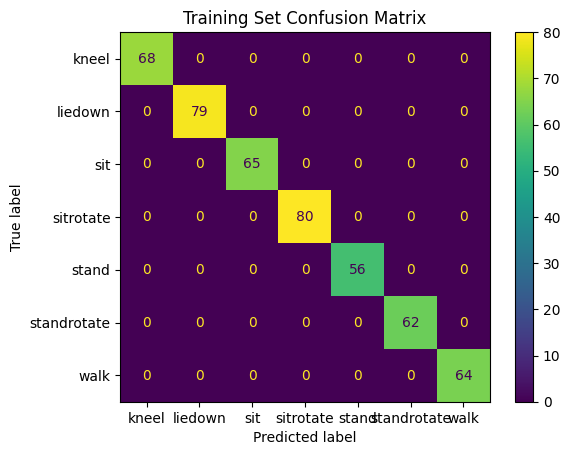

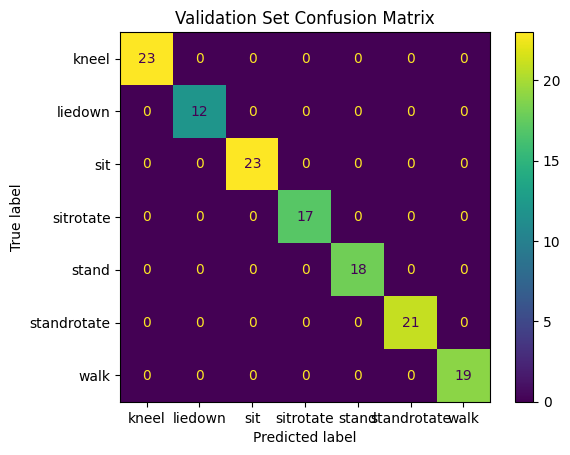

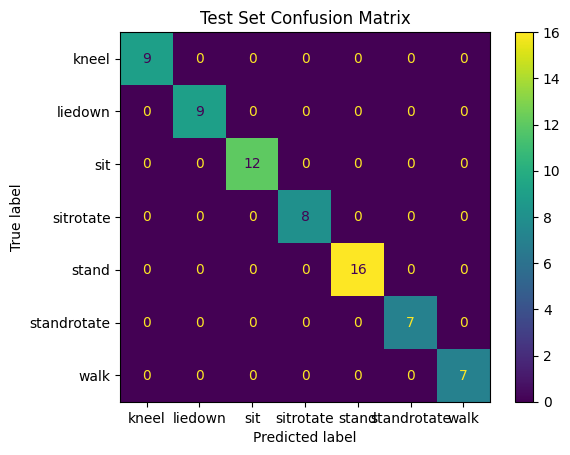

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, classification_report, f1_score

print('Training set report')
print(classification_report(np.argmax(y_train, axis=1), y_pred_tr, target_names=encoder.categories_[0]))
print('Validation set report')
print(classification_report(np.argmax(y_val, axis=1), y_pred_val, target_names=encoder.categories_[0]))
print('Test set report') 
print(classification_report(np.argmax(y_test, axis=1), y_pred_te, target_names=encoder.categories_[0]))

plt.figure(1)
ConfusionMatrixDisplay.from_predictions(np.argmax(y_train, axis=1), y_pred_tr, display_labels=encoder.categories_[0])
plt.title('Training Set Confusion Matrix')
plt.figure(2)
ConfusionMatrixDisplay.from_predictions(np.argmax(y_val, axis=1), y_pred_val, display_labels=encoder.categories_[0])
plt.title('Validation Set Confusion Matrix')
plt.figure(3)
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), y_pred_te, display_labels=encoder.categories_[0])
plt.title('Test Set Confusion Matrix')
plt.show()

# Reshaping Data and training SVM Model Method #2

In [14]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Flatten y_train, y_val, and y_test to 1-dimensional arrays
y_train_flat = np.argmax(y_train, axis=1)
y_val_flat = np.argmax(y_val, axis=1)
y_test_flat = np.argmax(y_test, axis=1)

# Train the SVM model
svm_model = svm.SVC()
svm_model.fit(X_train_flat, y_train_flat)

# Evaluate the model on the test set
accuracy = svm_model.score(X_test_flat, y_test_flat)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


# Scikit-learn's SVC

Test Accuracy: 1.0


<Figure size 800x600 with 0 Axes>

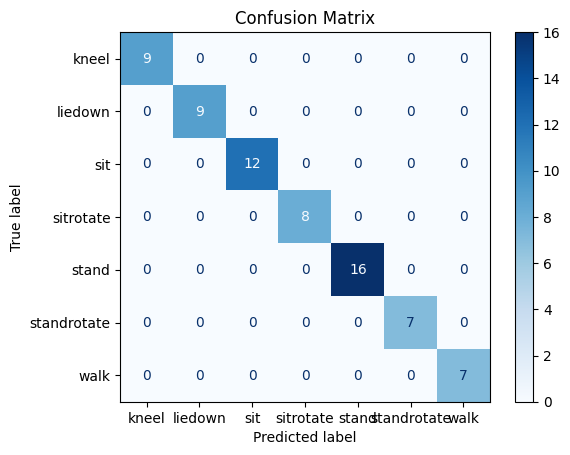

In [15]:
from sklearn.svm import SVC

# Create an instance of the SVC classifier
svm_model = svm.SVC(kernel='rbf', C=1.0, gamma='scale', decision_function_shape='ovr', random_state=42)

# Train the SVM model
svm_model.fit(X_train_reshaped, np.argmax(y_train, axis=1))

# Make predictions on the test set
y_test_pred = svm_model.predict(X_test_reshaped)

# Evaluate the model
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred)
print("Test Accuracy:", accuracy)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), y_test_pred, display_labels=encoder.categories_[0], cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Using Keras with an SVM Loss Function

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import hinge

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_reshaped.shape[1],)),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='linear')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss=hinge, metrics=['accuracy'])
model.fit(X_train_reshaped, y_train, batch_size=32, epochs=10, validation_data=(X_val_reshaped, y_val))

Epoch 1/10
15/15 [==============================] - 21s 1s/step - loss: 47.8227 - accuracy: 0.1582 - val_loss: 28.7087 - val_accuracy: 0.1579
Epoch 2/10
15/15 [==============================] - 12s 826ms/step - loss: 21.4343 - accuracy: 0.1624 - val_loss: 25.8150 - val_accuracy: 0.1579
Epoch 3/10
15/15 [==============================] - 12s 803ms/step - loss: 23.8724 - accuracy: 0.1899 - val_loss: 16.7311 - val_accuracy: 0.1729
Epoch 4/10
15/15 [==============================] - 12s 822ms/step - loss: 14.0956 - accuracy: 0.2004 - val_loss: 13.7582 - val_accuracy: 0.1429
Epoch 5/10
15/15 [==============================] - 12s 811ms/step - loss: 6.6915 - accuracy: 0.3038 - val_loss: 7.6593 - val_accuracy: 0.2331
Epoch 6/10
15/15 [==============================] - 12s 825ms/step - loss: 3.3436 - accuracy: 0.4557 - val_loss: 2.8938 - val_accuracy: 0.6165
Epoch 7/10
15/15 [==============================] - 12s 819ms/step - loss: 2.2984 - accuracy: 0.5232 - val_loss: 2.9228 - val_accuracy: 0